In [36]:
import numpy as np
import matplotlib.pyplot as plt

import yastn.yastn as yastn
from loopTNR import LoopTNR
from Ising import Ising_dense, Ising_critical_beta

### Free Energy density

The partition function of a $\sqrt{2}^n \times \sqrt{2}^n$ patch is
$$
Z = \text{Tr}(T^{\sqrt{2}^n \times \sqrt{2}^n}_0) 
= \text{Tr}(T^{\sqrt{2}^{n-1} \times \sqrt{2}^{n-1}}_1) \cdot \lambda_1^{2^{n-1}}
= \text{Tr}(T^{\sqrt{2}^{n-2} \times \sqrt{2}^{n-2}}_2) \cdot \lambda_1^{2^{n-1}} \lambda_2^{2^{n-2}} \\
=\text{Tr}(T^{\sqrt{2}^{2} \times \sqrt{2}^{2}}_{n-2}) 
\prod_{i=1}^{n-2} \lambda_i^{2^{n-i}},
$$
where $\lambda_i$ is the normalization constant of $T_i$. Therefore, the free-energy density is

$$
f = -\frac{1}{\beta 2^{n}} \ln Z = -\frac{1}{\beta}\left(\frac{1}{2^n}\ln \text{Tr}(T^{2\times 2}_{n-2})  +
 \sum_{i=1}^{n-2} \frac{1}{2^i} \ln \lambda_i \right)
$$

In [ ]:
def F_exact(beta):
    N = 10000;
    maglambda = 1/(np.sinh(2*beta)**2)
    x = np.linspace(0,np.pi,N+1)
    y = np.log(np.cosh(2*beta)*np.cosh(2*beta) + (1/maglambda)*np.sqrt(
            1+maglambda**2 -2*maglambda*np.cos(2*x)))
    return -1/beta*((np.log(2)/2) + 0.25*sum(y[1:(N+1)] + y[:N])/N)

def post_processing(TNR):
    normalizations = []
    for site in TNR.psi.sites():
        norm = TNR.psi[site].norm(p='inf')
        TNR.psi[site] = TNR.psi[site]/norm
        normalizations.append(norm)
    return normalizations

def trace_2x2(TNR):
    t1, t2, t3, t4 = TNR.psi[(0,0)], TNR.psi[(0,1)], TNR.psi[(1,1)], TNR.psi[(1, 0)]
    L = yastn.tensordot(t1, t4, axes=((0, 2), (2, 0)))
    R = yastn.tensordot(t2, t3, axes=((0, 2), (2, 0)))
    return yastn.tensordot(L, R, axes=((0, 1, 2, 3), (1, 0, 3, 2))).to_number()


In [ ]:
beta_c = Ising_critical_beta()
Free_energies = []

D_max = 12
max_sweeps = 20
betas = np.linspace(beta_c-0.2, beta_c+0.2, 20)
for beta in betas:
    psi = Ising_dense(beta=beta, h=0.0)
    loop_tnr = LoopTNR(psi, D_max)

    res = 0
    for step in range(10):
        truncate_err = loop_tnr.rg(max_sweeps, filter_max_sweeps=5000, filter_threshold=1e-5, loop_threshold=1e-7)
        norms = post_processing(loop_tnr)
        res += np.sum(np.log(norms))/len(norms)/2**(step+1)
        print(f"beta={beta}, truncation error={truncate_err}")

    f = -1/beta *(res + np.log(trace_2x2(loop_tnr))/2**(step+3)).real
    Free_energies.append(f/2) # a single tensor represents \sqrt{2} \times \sqrt{2} patch

beta=0.24068679350977146, truncation error=0
beta=0.24068679350977146, truncation error=0
beta=0.24068679350977146, truncation error=0


/opt/homebrew/Caskroom/miniforge/base/envs/torch_peps/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/homebrew/Caskroom/miniforge/base/envs/torch_peps/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


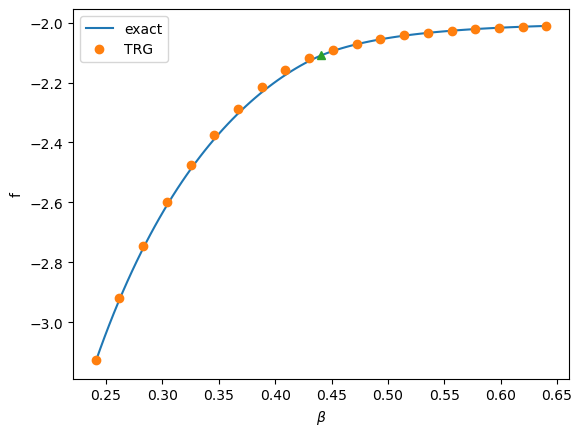

In [39]:
def plot_free_energy(betas, free_energies):
    beta_dense = np.linspace(np.min(betas), np.max(betas), 100)
    Free_energies_exact = [F_exact(beta) for beta in beta_dense]
    fig, ax = plt.subplots()
    ax.plot(beta_dense, Free_energies_exact, label="exact")
    ax.plot(betas, Free_energies, lw=0, marker='o', label='TRG')
    ax.plot(beta_c, F_exact(beta_c), lw=0, marker='^')
    ax.legend()
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel("f")

plot_free_energy(betas, Free_energies)